<a href="https://colab.research.google.com/github/Fathimath-Rifna-VK/fmml2021/blob/main/Module_10_FMML_M10_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

In this lab, we are going to take a look at what autoencoders are, how they are implemented, one of their applications and its comparison with PCA

> TODO: will replace MNIST with a more suitable dataset
As part of the initial discussion, it was decided that we should use faces. I feel a convolutional autoencoder will be better for that job.

For this purpose, we'll attempt to compress the 28x28 MNIST images (784 features) into a smaller representation by training an Autoencoder.

## Imports

In [ ]:
import operator as op
from functools import reduce

import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn import datasets as sk_datasets, decomposition
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

## Setting up the dataset

We'll be using the Autoencoder on the MNIST dataset

The `torchvision` module supports a lot of datasets that can be downloaded and used with torch without much hassle

In [ ]:
# These transforms will be run on each image
transform = transforms.Compose([
    # convert the image to a tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

print(train_set)

## Model

Basically, we'll have two components:
 - **Encoder**: Although similar to a conventional feed-forward network, it is not tasked on predicting values or labels. Instead, it is tasked to learn how the data is structured
 - **Decoder**: Also similar to a feed-forward network, instead of reducing data to a lower dimension, it reconstructs the data from its lower dimension representation to its original dimension

We'll pass our input through the encoder, (which will also the number of features with each layer) to get some embedding. Then, we'll pass this through the decoder, which will "upscale" the embedding into the original input shape.

We train this whole setup so that the encoder gets better at extracting the essential features and the decoder gets better at using those features for getting back the original input

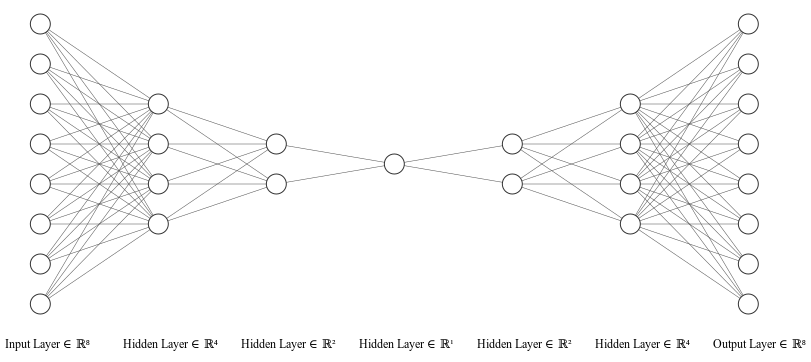

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_feature_counts):
        """
        Args:
            layer_feature_counts: A list, containing the number of features at each layer
        """
        super().__init__()
        
        encoder_layers = []
        for i in range(len(layer_feature_counts) - 1):
            encoder_layers.append(nn.Linear(in_features=layer_feature_counts[i], out_features=layer_feature_counts[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        # reverse the feature count list for decoder
        layer_feature_counts = layer_feature_counts[::-1]

        decoder_layers = []
        for i in range(len(layer_feature_counts) - 1):
            decoder_layers.append(nn.Linear(in_features=layer_feature_counts[i], out_features=layer_feature_counts[i+1]))
            decoder_layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoding = self.encoder(x)
        decoded = self.decoder(encoding)

        return decoded

## Architecture

Note that the decoder doesn't necessarily need to have the reversed layout of the encoder, only the input and output dimensions matter. For simplicity here, we use the same number of features in both

In [ ]:
# @title Embedding Feature Count {"run": "auto"}
# input size
inp_size = reduce(op.mul, train_set[0][0].size(), 1)
# output / compressed size
out_size = 16 # @param {type:"integer"}

# you can play around with these values
# make sure you don't mess up the input dimension
layer_feature_counts = [inp_size, 256, 64, out_size]
print(layer_feature_counts)

In [ ]:
ae = AutoEncoder(layer_feature_counts)
print(ae)

## Training setup

In [ ]:
# @title Hyperparams {"run": "auto"}
n_epochs = 100# @param {"type":"integer"}
learning_rate = 1e-3# @param {"type": "number"}
loss_fn = nn.MSELoss()
optim_fn = optim.Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

## Training the model

In [ ]:
def train(model, train_loader, n_epochs, lr, criterion, optim_fn, device):
    model = model.to(device)
    optimizer = optim_fn(model.parameters(), lr)
    loss_history = []

    with tqdm(range(n_epochs)) as prog_bar:
        for epoch in prog_bar:
            epoch_loss = 0
    
            # we are ignoring the labels
            for x, _ in train_loader:
                # move to correct device and flatten the image
                x = x.to(device).view(x.size(0), -1)
                optimizer.zero_grad()
    
                # the decoded encoder output
                out = model(x)
    
                loss = criterion(out, x)
                loss.backward()
                optimizer.step()
    
                epoch_loss += loss
            
            epoch_loss /= len(train_loader)
            prog_bar.set_description(f"loss: {epoch_loss}")
            loss_history.append(epoch_loss.detach())
    
    return loss_history

In [ ]:
loss_history = train(ae, train_loader, n_epochs, learning_rate, loss_fn, optim_fn, device)

## Analysis
Let's say that there is some application that needs to transfer a lot of MNIST images over the network. Instead of sending the full image (28x28 = 784), we have a compact encoding for the MNIST data (which only has 16 features).

We encode the image, send over the embedding then decode it at the other side. The only setup needed is to transfer the model weights ONCE.

In [ ]:
# take note of this value
# make changes and compare how many parameters your new modified autoencoder needs
# note that this is not the number of values sent over the network
# this represents the initial data transfer that must be done
print(f"Number of parameters: {sum(p.numel() for p in ae.parameters())}")

In [ ]:
img = test_set[0][0]

In [ ]:
def compare_outputs(model, img):
    to_pil = transforms.ToPILImage()
    orig_img = to_pil(img)

    # encode the actual image
    encoding = model.encoder(img.to(device).view(-1))

    # -----
    # send the image to the other device...
    # -----

    # decode the embedding
    decoded = model.decoder(encoding)

    decoded_img = to_pil(decoded.view(*img.size()))
    plt.imshow(np.hstack([orig_img, decoded_img]), cmap="gray")

    return encoding, decoded_img

In [ ]:
encoding, _ = compare_outputs(ae, img)

# Comparison with PCA

Now, we'll use PCA to try and achieve the same target and we'll compare and contrast these solutions

We don't expect a PCA to do so well with such a low number of dimensions.

Why?
- PCA is essentially a linear transformation but Auto-encoders are capable of modelling complex non linear functions.
- PCA features are totally linearly uncorrelated with each other since features are projections onto the orthogonal basis. But autoencoded features might have correlations since they are just trained for accurate reconstruction.
- PCA is faster and computationally cheaper than autoencoders.
- A single layered autoencoder with a linear activation function is very similar to PCA.

In [ ]:
# convert data so that it can be processed by sklearn
X = []
for i in tqdm(range(len(train_set))):
    X.append(train_set[i][0].flatten().numpy())

X = np.array(X)

In [ ]:
pca = decomposition.PCA(n_components=out_size)
pca.fit(X)

In [ ]:
def compare_sklearn_outputs(pca, X):
    X_pca = pca.transform(X)
    original = X[0]
    X_pca_inv = pca.inverse_transform(X_pca)
    pca_decoded = X_pca_inv[0]

    original = original.reshape(1, 28, 28)
    pca_decoded = pca_decoded.reshape(1, 28, 28)

    to_pil = transforms.ToPILImage()
    original = to_pil(torch.from_numpy(original))
    pca_decoded = to_pil(torch.from_numpy(pca_decoded))
    plt.imshow(np.hstack([original, pca_decoded]), cmap="gray")

compare_sklearn_outputs(pca, X)

# Excercises
 - Think of ways to automatically try and detect how good the decoded outputs are
    - An obvious but not-so-good idea can be using a classifier. Try to discuss why this isn't such a good idea
 - Try to play around with parameters, loss, etc and try to reach the most optimum quality-data tradeoff

## References
- [Implementing an Autoencoder in PyTorch](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1)
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- https://towardsdatascience.com/autoencoders-vs-pca-when-to-use-which-73de063f5d7

 add intermediate outputs during training

 more outputs, viusalization